In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd

from glob import glob
import tensorflow as tf

#to make plots look nice
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_validate

2022-11-25 15:25:56.862737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-25 15:25:56.862880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Importing audio files

In [2]:
audio_files = glob("data/Emotion_Dataset/*/*.wav")

# Preprocessing

- vectorizing every files with librosa load
- trimming the blank spaces
- padding (is it relevant with random forest?)
- melspectrogram
- appending to a list
- making it a numpy array

In [3]:
spectrograms = []
for item in audio_files:
    X, sr = librosa.load(item) #vectorizing
    X_trim = librosa.effects.trim(X,top_db=35) #trimming data
    
    #padding
    if X_trim[0].shape[0] >= 65000:
        X_final = X_trim[0][:65000]
        X_final = tf.convert_to_tensor(X_final).numpy()
    else:
        zero_padding = tf.zeros([65000]-tf.shape(X_trim[0]),dtype=tf.float32)
        X_final = tf.concat([X_trim[0],zero_padding],0).numpy()
        
    #mel spectogram
    S = librosa.feature.melspectrogram(y=X_final,
                                   sr=sr,
                                   n_mels=128,)
    
    #S = tf.expand_dims(S, axis=2)
    spectrograms.append(S)

2022-11-25 15:26:08.954740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-25 15:26:08.954946: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-25 15:26:08.955037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-23E8V41): /proc/driver/nvidia/version does not exist
2022-11-25 15:26:08.974840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [134]:
X= np.array(spectrograms)
X1= np.array(spectrograms)

In [5]:
X.shape

(1440, 128, 127)

# Target Encoding

In [103]:
ids=[]
for audio in audio_files:
    ids.append(audio[30:-4])

new_df = pd.DataFrame(ids)
new_df.rename(columns={0: "titulo"},inplace=True)
new_df['emotion'] = new_df.apply(lambda x: x[0].split("-")[2], axis=1)
y = new_df['emotion']

In [7]:
pd.DataFrame(y)

,emotion
0,01
1,06
2,08
3,05
4,06
...,...
1435,02
1436,06
1437,04
1438,08


# Splitting train test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modeling Random Forest

## flattening the spectogram

In [9]:
X_flat=X_train.reshape(1008,128*127)

In [10]:
y_train.shape

(1008,)

In [11]:
X_flat.shape

(1008, 16256)

## random forest

In [12]:
clf = RandomForestClassifier(max_depth=10,n_estimators=1000)
clf.fit(X_flat,y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000)

## Prediction and metrics

In [13]:
y_pred=clf.predict(X_test.reshape(432,128*127))
#cross_validate(clf,y_test,y_pred,scoring='accuracy')

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5439814814814815

In [15]:
df1 = pd.DataFrame(y_test).reset_index()
df2 = pd.DataFrame(y_pred)

In [16]:
df2

,0
0,03
1,07
2,07
3,05
4,06
...,...
427,08
428,08
429,03
430,07


In [17]:
df_check = df1.join(df2)
df_check.rename(columns={0:'pred'})

,index,emotion,pred
0,168,03,03
1,605,07,07
2,548,04,07
3,65,03,05
4,628,06,06
...,...,...,...
427,591,05,08
428,1133,05,08
429,1190,03,03
430,438,07,07


In [18]:
import xgboost as xgb
from xgboost import XGBClassifier

/home/lucas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
model_xgb=XGBClassifier(n_estimators=1000,max_depth=12,n_jobs=-1) #max_depth=12,

In [20]:
#model_xgb.fit(X_flat,y_train)

In [21]:
#y_pred=model_xgb.predict(X_test.reshape(432,128*127))
#accuracy_score(y_test,y_pred)
#0.5162

# Getting more audio - Savee

## getting audio

In [22]:
audio_files_2 = glob("data/Savee/*.wav")

In [23]:
audio_files_2

['data/Savee/DC_f01.wav',
 'data/Savee/JE_d06.wav',
 'data/Savee/KL_d07.wav',
 'data/Savee/DC_n20.wav',
 'data/Savee/JK_h10.wav',
 'data/Savee/KL_h02.wav',
 'data/Savee/JE_h12.wav',
 'data/Savee/JE_sa06.wav',
 'data/Savee/JE_su03.wav',
 'data/Savee/KL_sa01.wav',
 'data/Savee/DC_d05.wav',
 'data/Savee/KL_n14.wav',
 'data/Savee/JE_a13.wav',
 'data/Savee/KL_n25.wav',
 'data/Savee/JE_n17.wav',
 'data/Savee/JK_sa13.wav',
 'data/Savee/KL_sa04.wav',
 'data/Savee/JE_n20.wav',
 'data/Savee/DC_a13.wav',
 'data/Savee/JE_h05.wav',
 'data/Savee/JE_n04.wav',
 'data/Savee/JE_su14.wav',
 'data/Savee/DC_d11.wav',
 'data/Savee/KL_a06.wav',
 'data/Savee/DC_su10.wav',
 'data/Savee/DC_n24.wav',
 'data/Savee/JE_n06.wav',
 'data/Savee/DC_d10.wav',
 'data/Savee/DC_su14.wav',
 'data/Savee/JE_n24.wav',
 'data/Savee/KL_sa05.wav',
 'data/Savee/KL_f10.wav',
 'data/Savee/DC_h09.wav',
 'data/Savee/JK_a08.wav',
 'data/Savee/JE_f10.wav',
 'data/Savee/JE_sa01.wav',
 'data/Savee/KL_f04.wav',
 'data/Savee/KL_f02.wav',
 '

In [24]:
audio_files_2[0][14:-6]

'f'

## targeting

In [25]:
ids=[]
for audio in audio_files_2:
    ids.append(audio[14:-6])

new_df = pd.DataFrame(ids)
new_df.rename(columns={0: "emotion"},inplace=True)
#new_df['emotion'] = new_df.apply(lambda x: x[0].split("-")[2], axis=1)
#y2 = new_df['emotion']
#y2

In [26]:
new_df

,emotion
0,f
1,d
2,d
3,n
4,h
...,...
475,d
476,a
477,su
478,n


In [28]:
#savee
#'a' = 'anger'
#'d' = 'disgust'
#'f' = 'fear'
#'h' = 'happiness'
#'n' = 'neutral'
#'sa' = 'sadness'
#'su' = 'surprise'

In [31]:
#ravdess
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [32]:
translate_emotion = {
    'a':'05',
    'd':'07',
    'f':'06',
    'h':'03',
    'n':'01',
    'sa':'04',
    'su':'08'    
}

In [33]:
new_df = new_df.replace({'emotion':translate_emotion})
y2 = new_df['emotion']
y2

0      06
1      07
2      07
3      01
4      03
       ..
475    07
476    05
477    08
478    01
479    03
Name: emotion, Length: 480, dtype: object

## finding X2

In [34]:
spectrograms_2 = []
for item in audio_files_2:
    X, sr = librosa.load(item) #vectorizing
    X_trim = librosa.effects.trim(X,top_db=35) #trimming data
    
    #padding
    if X_trim[0].shape[0] >= 65000:
        X_final = X_trim[0][:65000]
        X_final = tf.convert_to_tensor(X_final).numpy()
    else:
        zero_padding = tf.zeros([65000]-tf.shape(X_trim[0]),dtype=tf.float32)
        X_final = tf.concat([X_trim[0],zero_padding],0).numpy()
        
    #mel spectogram
    S = librosa.feature.melspectrogram(y=X_final,
                                   sr=sr,
                                   n_mels=128,)
    
    #S = tf.expand_dims(S, axis=2)
    spectrograms_2.append(S)

In [35]:
X2= np.array(spectrograms_2)

In [36]:
X2.shape

(480, 128, 127)

In [37]:
y2.shape

(480,)

## accuracy testing

In [38]:
# load the model from disk
import pickle
filename = 'models/54,6_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))


In [39]:
y_pred=loaded_model.predict(X2.reshape(480,128*127))
accuracy_score(y2,y_pred)

0.13958333333333334

## Confusion Matrix

/home/lucas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


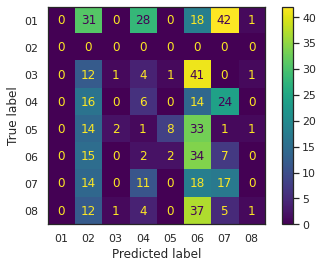

In [40]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(loaded_model,X2.reshape(480,128*127),y2)

# Training new model - Savee+ravdess

## X and y

In [41]:
#X_all = np.append(X_train,X_test,axis=0)
X_all = np.append(X1,X2,axis=0)
X_all.shape

(1920, 128, 127)

In [42]:
y_all = np.append(y,y2,axis=0)
y_all.shape

(1920,)

## split and flat

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

In [44]:
X_train2.shape

(1344, 128, 127)

In [45]:
X_flat2=X_train2.reshape(1344,128*127)

## creating model and testing

In [46]:
model_tuned = RandomForestClassifier(max_depth=12,min_samples_split=4,n_estimators=1000)
model_tuned.fit(X_flat2,y_train2)

RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=1000)

In [47]:
y_pred2=model_tuned.predict(X_test2.reshape(X_test2.shape[0],128*127))
accuracy_score(y_test2,y_pred2)

0.18055555555555555

/home/lucas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


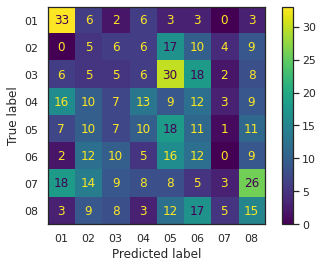

In [48]:
plot_confusion_matrix(model_tuned,X_test2.reshape(X_test2.shape[0],128*127),y_test2)

# Getting even more audio (tess)

## getting audio

In [75]:
audio_files_3 = glob("data/Tess/*.wav")

In [50]:
audio_files_3

['data/Tess/YAF_wife_angry.wav',
 'data/Tess/YAF_search_ps.wav',
 'data/Tess/OAF_calm_fear.wav',
 'data/Tess/YAF_germ_happy.wav',
 'data/Tess/YAF_such_disgust.wav',
 'data/Tess/YAF_third_angry.wav',
 'data/Tess/YAF_bar_happy.wav',
 'data/Tess/OAF_keen_sad.wav',
 'data/Tess/YAF_kick_fear.wav',
 'data/Tess/OAF_lore_neutral.wav',
 'data/Tess/YAF_door_ps.wav',
 'data/Tess/YAF_date_happy.wav',
 'data/Tess/OAF_phone_angry.wav',
 'data/Tess/OAF_lean_ps.wav',
 'data/Tess/YAF_pick_neutral.wav',
 'data/Tess/OAF_long_disgust.wav',
 'data/Tess/OAF_bar_fear.wav',
 'data/Tess/YAF_bean_fear.wav',
 'data/Tess/OAF_match_happy.wav',
 'data/Tess/YAF_keg_disgust.wav',
 'data/Tess/OAF_room_happy.wav',
 'data/Tess/YAF_get_disgust.wav',
 'data/Tess/OAF_mill_angry.wav',
 'data/Tess/YAF_chat_fear.wav',
 'data/Tess/OAF_road_sad.wav',
 'data/Tess/YAF_laud_neutral.wav',
 'data/Tess/OAF_page_sad.wav',
 'data/Tess/OAF_shall_sad.wav',
 'data/Tess/OAF_take_disgust.wav',
 'data/Tess/OAF_cab_neutral.wav',
 'data/Tess/O

## targeting y

In [51]:
audio_files_3[0].split("_")[-1][:-4]

'angry'

In [52]:
ids=[]
for audio in audio_files_3:
    ids.append(audio.split("_")[-1][:-4])

tess_df = pd.DataFrame(ids)
tess_df.rename(columns={0: "emotion"},inplace=True)

In [53]:
tess_df.value_counts()

emotion
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        200
dtype: int64

In [54]:
emo_relation ={
    'angry':'05',
    'disgust':'07',
    'fear':'06',
    'happy':'03',
    'neutral':'01',
    'ps':'08',
    'sad':'04'
}
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [55]:
tess_df = tess_df.replace({'emotion':emo_relation})
tess_df

,emotion
0,05
1,08
2,06
3,03
4,07
...,...
2595,07
2596,07
2597,03
2598,06


In [56]:
y3=tess_df["emotion"]
y3

0       05
1       08
2       06
3       03
4       07
        ..
2595    07
2596    07
2597    03
2598    06
2599    08
Name: emotion, Length: 2600, dtype: object

## finding X3

In [57]:
spectrograms_3 = []
for item in audio_files_3:
    X, sr = librosa.load(item) #vectorizing
    X_trim = librosa.effects.trim(X,top_db=35) #trimming data
    
    #padding
    if X_trim[0].shape[0] >= 65000:
        X_final = X_trim[0][:65000]
        X_final = tf.convert_to_tensor(X_final).numpy()
    else:
        zero_padding = tf.zeros([65000]-tf.shape(X_trim[0]),dtype=tf.float32)
        X_final = tf.concat([X_trim[0],zero_padding],0).numpy()
        
    #mel spectogram
    S = librosa.feature.melspectrogram(y=X_final,
                                   sr=sr,
                                   n_mels=128,)
    
    #S = tf.expand_dims(S, axis=2)
    spectrograms_3.append(S)

In [58]:
X3= np.array(spectrograms_3)

In [59]:
X3.shape

(2600, 128, 127)

## testing on best model

In [60]:
import pickle
filename = 'models/54,6_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))


In [61]:
from sklearn.metrics import accuracy_score

In [62]:
y_pred=loaded_model.predict(X3.reshape(2600,128*127))
accuracy_score(y3,y_pred)

0.2623076923076923

/home/lucas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


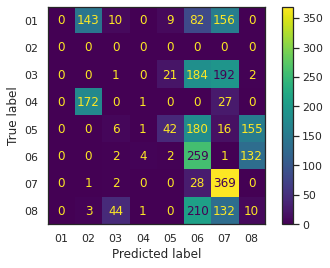

In [63]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(loaded_model,X3.reshape(2600,128*127),y3)

## Training new model

In [64]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=42)

In [65]:
X_flat3=X_train3.reshape(X_train3.shape[0],128*127)

In [66]:
model_tuned_2 = RandomForestClassifier(max_depth=12,min_samples_split=4,n_estimators=1000)
model_tuned_2.fit(X_flat3,y_train3)

RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=1000)

In [67]:
y_pred3=model_tuned_2.predict(X_test3.reshape(X_test3.shape[0],128*127))
accuracy_score(y_test3,y_pred3)

0.9807692307692307

/home/lucas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


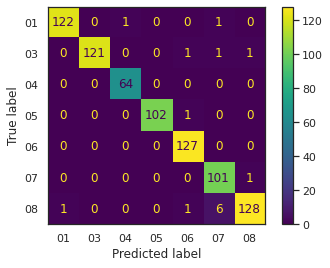

In [68]:
plot_confusion_matrix(model_tuned_2,X_test3.reshape(X_test3.shape[0],128*127),y_test3)

In [69]:
#filename = 'tess_model.sav'
#pickle.dump(model_tuned_2, open(filename, 'wb'))

## testing tess model with other datasets

In [71]:
X_ravdess = np.append(X_train,X_test,axis=0)
y_pred=model_tuned_2.predict(X_ravdess.reshape(X_ravdess.shape[0],128*127))
accuracy_score(y,y_pred)

0.13819444444444445

In [72]:
#It doesnt generalize well

# Crema dataset

In [74]:
audio_files_4 = glob("data/Crema/*.wav")

In [83]:
audio_files_4[-1]

'data/Crema/1075_IEO_ANG_HI.wav'

In [88]:
ids=[]
for audio in audio_files_4:
    ids.append(audio[20:-7])

new_df = pd.DataFrame(ids)
new_df.rename(columns={0: "emotion"},inplace=True)

In [90]:
new_df.value_counts()

emotion
ANG        1271
DIS        1271
FEA        1271
HAP        1271
SAD        1271
NEU        1087
dtype: int64

In [91]:
emo_relation ={
    'ANG':'05',
    'DIS':'07',
    'FEA':'06',
    'HAP':'03',
    'NEU':'01',
    'SAD':'04'
}
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [92]:
new_df = new_df.replace({'emotion':emo_relation})
new_df

,emotion
0,04
1,06
2,07
3,04
4,03
...,...
7437,04
7438,07
7439,06
7440,07


In [96]:
y4=new_df['emotion']

In [94]:
spectrograms_4 = []
for item in audio_files_4:
    X, sr = librosa.load(item) #vectorizing
    X_trim = librosa.effects.trim(X,top_db=35) #trimming data
    
    #padding
    if X_trim[0].shape[0] >= 65000:
        X_final = X_trim[0][:65000]
        X_final = tf.convert_to_tensor(X_final).numpy()
    else:
        zero_padding = tf.zeros([65000]-tf.shape(X_trim[0]),dtype=tf.float32)
        X_final = tf.concat([X_trim[0],zero_padding],0).numpy()
        
    #mel spectogram
    S = librosa.feature.melspectrogram(y=X_final,
                                   sr=sr,
                                   n_mels=128,)
    
    #S = tf.expand_dims(S, axis=2)
    spectrograms_4.append(S)

In [95]:
X4= np.array(spectrograms_4)
X4.shape

(7442, 128, 127)

## testing on previous models

In [97]:
y_pred=model_tuned_2.predict(X4.reshape(X4.shape[0],128*127))
accuracy_score(y4,y_pred)

0.20169309325450147

In [98]:
y_pred=loaded_model.predict(X4.reshape(X4.shape[0],128*127))
accuracy_score(y4,y_pred)

0.21835528083848427

## training new model

In [99]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=42)

In [100]:
X_flat4=X_train4.reshape(X_train4.shape[0],128*127)

In [101]:
model_crema = RandomForestClassifier(max_depth=12,min_samples_split=4,n_estimators=1000)
model_crema.fit(X_flat4,y_train4)

RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=1000)

In [102]:
y_pred4=model_crema.predict(X_test4.reshape(X_test4.shape[0],128*127))
accuracy_score(y_test4,y_pred4)

0.45499328257948946

/home/lucas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


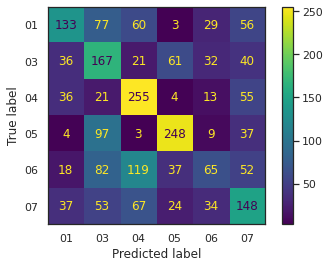

In [107]:
plot_confusion_matrix(model_crema,X_test4.reshape(X_test4.shape[0],128*127),y_test4)

## test them on the other datasets

In [104]:
#ravdess
y_pred=model_crema.predict(np.append(X_train,X_test,axis=0).reshape(np.append(X_train,X_test,axis=0).shape[0],128*127))
accuracy_score(y,y_pred)

0.12986111111111112

In [105]:
#savee
y_pred=model_crema.predict(X2.reshape(X2.shape[0],128*127))
accuracy_score(y2,y_pred)

0.17291666666666666

In [106]:
#tess
y_pred=model_crema.predict(X3.reshape(X3.shape[0],128*127))
accuracy_score(y3,y_pred)

0.20846153846153845

In [110]:
#lets try to save the variable in a pickle model
#filename = 'X4.sav'
#pickle.dump(X4, open(filename, 'wb'))


# Stacking everything together

- lets train all data and try to figure out a general model.
- lets stack all Xs and all Ys together
- lets drop some emotions to make it easy for our model

## X and y

In [120]:
#y+y2+y3+y4
temp = np.append(y,y2,axis=0)
temp = np.append(temp,y3,axis=0)
y_stacked = np.append(temp,y4,axis=0)
temp =[]
y_stacked.shape

(11962,)

In [ ]:
new_df = pd.DataFrame(y_stacked)
new_df.rename(columns={0: "emotion"},inplace=True)
y_stacked = new_df['emotion']

In [ ]:
#X2+X3+X4+X_train+X_test
#temp = np.append(X_train,X_test,axis=0)
temp = np.append(X1,X2,axis=0)
temp = np.append(temp,X3,axis=0)
X_stacked = np.append(temp,X4,axis=0)
temp = []
X_stacked.shape

In [133]:
#stack in same df
df_stack =pd.concat([pd.DataFrame(y_stacked),pd.DataFrame(X_stacked.reshape(X_stacked.shape[0],128*127))],axis=1)

,0,0,1,2,3,4,5,6,7,8,...,16246,16247,16248,16249,16250,16251,16252,16253,16254,16255
0,01,2.203027e-03,1.170251e-02,4.455282e-01,3.819107e+00,2.298981e+01,101.363251,135.918549,96.590721,6.577298e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,06,1.060637e-07,2.946360e-07,1.580506e-06,4.227112e-05,5.170397e-04,0.000904,0.000852,0.001354,2.152896e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,08,2.738150e-07,1.728752e-07,2.758381e-07,3.049385e-07,8.543942e-07,0.000001,0.000001,0.000001,7.316910e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,05,1.115933e-04,1.910397e-04,1.771309e-04,7.495625e-04,1.435968e-03,0.001809,0.000911,0.000362,3.548892e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,06,2.002969e-02,2.110533e-02,1.365672e-02,7.612080e-03,5.840269e-03,0.003148,0.002874,0.006182,1.110904e-02,...,1.073457e-06,6.810404e-07,5.144891e-07,4.907216e-07,4.705525e-07,2.588886e-07,1.686486e-07,1.148671e-07,5.107877e-08,8.781977e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11957,04,6.228230e-02,8.644083e-02,2.944090e-02,5.123207e-02,2.080762e-01,0.277888,0.167008,0.024872,3.766369e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11958,07,5.546933e-02,1.267934e-01,7.931565e-02,8.544661e-02,1.009162e-01,0.061718,0.064153,0.075251,4.684797e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
11959,06,3.290078e-02,1.835278e-01,2.439672e-01,1.318054e-01,8.092763e-02,0.057761,0.095689,0.115898,4.815014e-02,...,7.680029e-17,7.587674e-17,8.036695e-17,7.670479e-17,5.166662e-17,5.895734e-17,4.922118e-17,6.648612e-17,5.373811e-13,8.026702e-08
11960,07,5.993700e-03,1.968046e-02,6.207709e-02,8.394147e-02,4.549056e-02,0.021034,0.011145,0.031406,1.145009e-01,...,5.438509e-17,6.966741e-17,1.007127e-16,7.689359e-17,4.879705e-17,1.258012e-15,7.132818e-14,8.846649e-14,4.198881e-15,0.000000e+00


In [ ]:
#count emotions
df_stack['emotion'].value_counts()

In [ ]:
#for info
# selecting rows based on condition
#rslt_df = dataframe[dataframe['Percentage'] > 80]

In [ ]:
#drop emotions
df_stack = df_stack[df_stack['emotion']!='02']
df_stack.shape

In [ ]:
#new_X and new_y
X_stacked = df_stack.drop(columns=['emotion'])
y_stacked = df_stack['emotion']

In [ ]:
#train/test split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_stacked, y_stacked, test_size=0.3, random_state=42)

In [ ]:
#make model
model_stacked = RandomForestClassifier(max_depth=12,min_samples_split=4,n_estimators=1000)
model_crema.fit(X_train5.reshape(X_train5.shape[0],128*127),y_train5)

In [ ]:
y_pred5=model_crema.predict(X_test5.reshape(X_test5.shape[0],128*127))
accuracy_score(y_test5,y_pred5)